In [2]:
from IPython.display import clear_output
import gym
import os, sys
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as f
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random
from memories import ExperienceReplay
import imp
from gym import wrappers
from gym.wrappers import AtariPreprocessing
import json
import qnet_agentsSAC_auto
import subprocess

%matplotlib inline

# Reading Parameters

In [3]:
print("reading parameters...")
config_file = "config02.json"
config = json.load(open(config_file))

#Id
configId = config["configId"]

#env
screen_size = config["env_parameters"]["screen_size"]
frame_skip = config["env_parameters"]["frame_skip"]
seed_value = config["env_parameters"]["seed_value"]

#agent
gamma = config["agent_parameters"]["gamma"]
lr_Q = config["agent_parameters"]["lr_Q"]
lr_pi = config["agent_parameters"]["lr_pi"]
lr_alpha = config["agent_parameters"]["lr_alpha"]
tau = config["agent_parameters"]["tau"]
h_dim = config["agent_parameters"]["h_dim"]
h_mu_dim = config["agent_parameters"]["h_mu_dim"]
alpha = config["agent_parameters"]["alpha"]
entropy_rate = config["agent_parameters"]["entropy_rate"]

#training
n_episodes = int(config["training_parameters"]["n_episodes"])
batch_size = config["training_parameters"]["batch_size"]
t_tot_cut = config["training_parameters"]["t_tot_cut"]


reading parameters...


# Setup

In [4]:
env = gym.make('SpaceInvaders-v4')
env.spec.id = 'SpaceInvaders-v4'+"NoFrameskip"

env = wrappers.AtariPreprocessing(env,grayscale_obs=True,frame_skip=frame_skip,grayscale_newaxis=True,screen_size=screen_size)

n_states = env.observation_space.shape[0]
n_actions = env.action_space.n

QNet_Agent = qnet_agentsSAC_auto.QNet_Agent
qnet_agent = QNet_Agent(n_states=n_states,
                        n_actions=n_actions,
                        gamma = gamma,
                        lr_Q = lr_Q,
                        lr_pi = lr_pi,
                        lr_alpha = lr_alpha,
                        tau = tau,
                        h_dim = h_dim,
                        h_mu_dim = h_mu_dim,
                        entropy_rate = entropy_rate,
                        alpha = alpha
                       ).cuda()
qnet_agent.Q.load_state_dict(torch.load("./saved_models/SpaceInvaders_Q_SAC_auto_{}.model".format(configId)))
qnet_agent.target_Q.load_state_dict(torch.load("./saved_models/SpaceInvaders_target_Q_SAC_auto_{}.model".format(configId)))
qnet_agent.pi.load_state_dict(torch.load("./saved_models/SpaceInvaders_pi_SAC_auto_{}.model".format(configId)))


<All keys matched successfully>

# Watch it!

In [5]:
save_video = False

def format_index(t):
    if t<10: return "000{}".format(t)
    elif t<100: return "00{}".format(t)
    elif t<1000: return "0{}".format(t)
    else: return "{}".format(t)

def generate_video(configId):
    makeVideoCommand = "ffmpeg -framerate 10 -f image2 -i ./videos/img%4d.jpg -y ./videos/{}.mp4".format(configId)
    process = subprocess.Popen(makeVideoCommand.split(), stdout=subprocess.PIPE)
    output, error = process.communicate()

    clearImgDataCommad = "rm ./videos/img*.jpg"
    res = subprocess.call(clearImgDataCommad, shell=True)


In [6]:
state = env.reset()
state = np.transpose(state, [2,0,1])


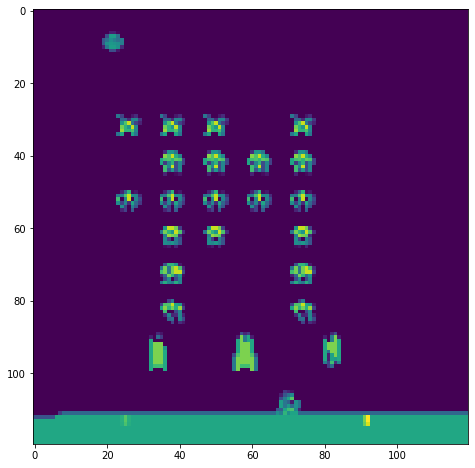

In [7]:
env = gym.make('SpaceInvaders-v4')
env.spec.id = 'SpaceInvaders-v4'+"NoFrameskip"
env = wrappers.AtariPreprocessing(env,grayscale_obs=True,frame_skip=frame_skip,grayscale_newaxis=True,screen_size=screen_size)

state = env.reset()
state = np.transpose(state, [2,0,1])

rewards = []
actions = []
t=0

while True:
    try:
        state_cuda = torch.Tensor(state).cuda().unsqueeze(0)
        action = qnet_agent.select_action(state_cuda)
        new_state, reward, done, info = env.step(action) 
        new_state = np.transpose(new_state, [2,0,1])
        
        state = new_state

        time.sleep(0.00001)
        clear_output(True)
        fig = plt.figure(figsize=(10,8))
        ax = fig.add_subplot(111)
        ax.imshow(np.transpose(state, [1,2,0]))
        
        if save_video:
            plt.savefig("./videos/img{}.jpg".format(format_index(t)))
        
        plt.show()
        t+=1
        
        if t>1e4:
            env.close()
            break
        if done: 
            env.close()
            break
    except KeyboardInterrupt:
        env.close()
        print("break")
        break

if save_video:
    generate_video(configId)